# Fine-tune IndoBERTweet dengan Huggingface API Trainer
Paper: Fajri Koto, Jey Han Lau, and Timothy Baldwin. IndoBERTweet: A Pretrained Language Model for Indonesian Twitter with Effective Domain-Specific Vocabulary Initialization. In Proceedings of the 2021 Conference on Empirical Methods in Natural Language Processing (EMNLP 2021), Dominican Republic (virtual).  
Github: https://github.com/indolem/IndoBERTweet

In [1]:
# Optional
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [109]:
NUM_LABELS =  3#@param {type:"integer"}
TRAIN_PATH_DATA_INPUT = "/content/drive/Shareddrives/DAC UNPAD: Yaudahlah/FINAL MENANG BISMILLAH/Data/Unbalance/NonStopword_Min2_Clean/clean_train.csv" #@param {type:"string"}
TEST_PATH_DATA_INPUT = "/content/drive/Shareddrives/DAC UNPAD: Yaudahlah/FINAL MENANG BISMILLAH/Data/Unbalance/NonStopword_Min2_Clean/clean_test.csv" #@param {type:"string"}

# Install Lib

In [3]:
!pip install transformers
!pip install datasets

     |████████████████████████████████| 2.9 MB 2.8 MB/s 
     |████████████████████████████████| 895 kB 51.2 MB/s 
     |████████████████████████████████| 636 kB 58.1 MB/s 
     |████████████████████████████████| 3.3 MB 26.5 MB/s 
     |████████████████████████████████| 52 kB 1.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 270 kB 3.9 MB/s 
     |████████████████████████████████| 1.3 MB 56.6 MB/s 
     |████████████████████████████████| 243 kB 71.2 MB/s 
     |████████████████████████████████| 125 kB 75.1 MB/s 
     |████████████████████████████████| 294 kB 73.9 MB/s 
     |████████████████████████████████| 142 kB 74.1 MB/s 


# Import Data dan Menyiapkannya
- Label harus dimulai dari 0
- Data text harus di preprocessing setidaknya seperti ini : 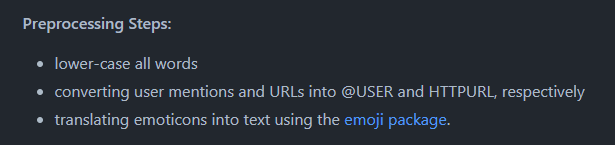

In [124]:
import pandas as pd
# Training Data Handling
df = pd.read_csv(TRAIN_PATH_DATA_INPUT)

from sklearn.model_selection import train_test_split
train_data, eval_data = train_test_split(df, shuffle=True, test_size=0.2)

train = train_data.drop(columns="raw", axis=1)
train = train.rename(columns={
    "processed" : "text",
    "labels" : "label"
})

eval = eval_data.drop(columns="raw", axis=1)
eval = eval.rename(columns={
    "processed" : "text",
    "labels" : "label"
})
######### Ini Harusnya ada di Pre-Processing ############
# mapping = {
#     -1 : 0,
#     1 : 1,
# }
# df['label']= df['label'].map(mapping)
# df = df.reset_index(drop=True)
#########################################################

# Testing Data Handling
df_test_raw = pd.read_csv(TEST_PATH_DATA_INPUT)
df_test_raw["label"] = df_test_raw["label"].map({"?" : -1})
df_test = df_test_raw.drop(columns="raw", axis=1)
df_test = df_test.rename(columns={
    "processed" : "text",
    "labels" : "label"
})

In [144]:
df_test_raw = pd.read_csv(TEST_PATH_DATA_INPUT)
df_test_raw["label"] = df_test_raw["label"].map({"?" : 0})
df_test = df_test_raw.drop(columns="raw", axis=1)
df_test = df_test.rename(columns={
    "processed" : "text",
    "labels" : "label"
})

In [145]:
train.to_csv("./train.csv", index=False)
eval.to_csv("./eval.csv", index=False)
df_test.to_csv("./test.csv", index=False)

In [146]:
from datasets import load_dataset
files = {"train": "/content/train.csv", 
         "eval": "/content/eval.csv", 
         "test":"/content/test.csv"
        }
dataset = load_dataset('csv', data_files=files)

Using custom data configuration default-a5036ba0a8a7253d


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-a5036ba0a8a7253d/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

## Tokenizing

In [128]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("indolem/indobertweet-base-uncased", use_fast=True)

loading configuration file https://huggingface.co/indolem/indobertweet-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/1bc74f926cfaba29a3efcd2c3987639d52b4bd3ae0db5ea988d9db3a2d89a82e.5a2e763d483214221769889b3a2ea7bec217b494a217b2ae98bb729f74881292
Model config BertConfig {
  "_name_or_path": "indolem/indobert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_ids": 0,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.2",
  "type_vocab_size": 2,
  "use_cache": t

In [147]:
def tokenize_function(examples):
    return tokenizer(str(examples["text"]), padding='max_length', max_length=256, truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=False)

  0%|          | 0/7848 [00:00<?, ?ex/s]

  0%|          | 0/1962 [00:00<?, ?ex/s]

  0%|          | 0/200 [00:00<?, ?ex/s]

In [130]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7848
    })
    eval: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1962
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 200
    })
})

In [131]:
train_dataset = tokenized_datasets["train"]
eval_dataset = tokenized_datasets["eval"]
test_dataset = tokenized_datasets["test"]

In [148]:
test_dataset = tokenized_datasets["test"]

## Modelling

In [132]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("indolem/indobertweet-base-uncased", num_labels=NUM_LABELS)

loading configuration file https://huggingface.co/indolem/indobertweet-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/1bc74f926cfaba29a3efcd2c3987639d52b4bd3ae0db5ea988d9db3a2d89a82e.5a2e763d483214221769889b3a2ea7bec217b494a217b2ae98bb729f74881292
Model config BertConfig {
  "_name_or_path": "indolem/indobert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_ids": 0,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "outp

# Training Preparation

In [133]:
from transformers import TrainingArguments

training_args = TrainingArguments("test_trainer")

# training_args = TrainingArguments(
#     output_dir="./running_trainer",
#     do_train=True,
#     evaluation_strategy="steps",
#     learning_rate=5e-8,
#     num_train_epochs=3,
#     save_strategy="epoch",
#     save_steps=200,
# )

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


# Training

In [134]:
from transformers import Trainer
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)
training_history = trainer.train()
evaluation_history = trainer.evaluate()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running training *****
  Num examples = 7848
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2943


Step,Training Loss
500,0.598900
1000,0.466300
1500,0.306500
2000,0.310200
2500,0.146900


Saving model checkpoint to test_trainer/checkpoint-500
Configuration saved in test_trainer/checkpoint-500/config.json
Model weights saved in test_trainer/checkpoint-500/pytorch_model.bin
Saving model checkpoint to test_trainer/checkpoint-1000
Configuration saved in test_trainer/checkpoint-1000/config.json
Model weights saved in test_trainer/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to test_trainer/checkpoint-1500
Configuration saved in test_trainer/checkpoint-1500/config.json
Model weights saved in test_trainer/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to test_trainer/checkpoint-2000
Configuration saved in test_trainer/checkpoint-2000/config.json
Model weights saved in test_trainer/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to test_trainer/checkpoint-2500
Configuration saved in test_trainer/checkpoint-2500/config.json
Model weights saved in test_trainer/checkpoint-2500/pytorch_model.bin


Training completed. Do not forget to share your mod

In [135]:
evaluation_history

{'epoch': 3.0,
 'eval_accuracy': 0.8476044852191641,
 'eval_loss': 0.7836902737617493,
 'eval_runtime': 17.832,
 'eval_samples_per_second': 110.027,
 'eval_steps_per_second': 13.795}

In [140]:
trainer.save_model('/content/drive/Shareddrives/DAC UNPAD: Yaudahlah/FINAL MENANG BISMILLAH/Final Model/IndoBERTweet NonStopwordNonStemMin2Clean 0.847')

Saving model checkpoint to /content/drive/Shareddrives/DAC UNPAD: Yaudahlah/FINAL MENANG BISMILLAH/Final Model/IndoBERTweet NonStopwordNonStemMin2Clean 0.847
Configuration saved in /content/drive/Shareddrives/DAC UNPAD: Yaudahlah/FINAL MENANG BISMILLAH/Final Model/IndoBERTweet NonStopwordNonStemMin2Clean 0.847/config.json


RuntimeError: ignored

In [149]:
prediction = trainer.predict(test_dataset)

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Prediction *****
  Num examples = 200
  Batch size = 8


RuntimeError: ignored

In [ ]:
prediction.predictions.argmax(1)

In [94]:
eval_data["Predict"] = prediction.predictions.argmax(1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [96]:
eval_data.to_csv("/content/drive/Shareddrives/DAC UNPAD: Yaudahlah/FINAL MENANG BISMILLAH/Error Analysis/IndoBERTweet NonStopwordNonStemMin2Clean 0.847.csv")

In [72]:
final_pred = prediction.predictions.argmax(1)
final_pred

array([1, 0, 1, ..., 0, 0, 0])

# Prediction on Testing Data

In [ ]:
test_history = trainer.evaluate(test_dataset)

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Prediction *****
  Num examples = 1662
  Batch size = 8


In [ ]:
a.predictions.argmax(1)

array([1, 0, 1, ..., 1, 1, 1])

In [138]:
!rm -fr "/content/drive/Shareddrives/DAC UNPAD: Yaudahlah/FINAL MENANG BISMILLAH/Final Model/IndoBERTweet NonStopword_Stemmed_Min2 0.839"